In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
# seaborn, just in case

In [163]:
fifa21 = pd.read_csv("fifa21_train.csv")
fifa21.head()

,ID,Name,Age,Nationality,Club,BP,Position,Team & Contract,Height,Weight,foot,Growth,Joined,Loan Date End,Value,Wage,Release Clause,Contract,Attacking,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending,Marking,Standing Tackle,Sliding Tackle,Goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,W/F,SM,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,184383,A. Pasche,26,Switzerland,FC Lausanne-Sport,CM,CM CDM,FC Lausanne-Sport 2015 ~ 2020,"5'9""",161lbs,Right,1,"Jul 1, 2015",NaN,€525K,€4K,€801K,2015 ~ 2020,258,54,47,43,70,44.0,286,61,44.0,55,63,63,346,64,73,61.0,66,82.0,306,62,73.0,71,55,45,290,54,52.0,62.0,68.0,54,54.0,148,49,56,43.0,48,7,12,14,9,6,1682,357,4 ★,2★,High,Medium,1 ★,69,51,63,63,51,60,3,58+1,58+1,58+1,61+0,62+0,62+0,62+0,61+0,63+1,63+1,63+1,63+1,63+1,63+1,63+1,63+1,59+1,59+1,59+1,59+1,59+1,58+1,54+1,54+1,54+1,58+1,15+1,64
1,188044,Alan Carvalho,30,China PR,Beijing Sinobo Guoan FC,ST,ST LW LM,"Beijing Sinobo Guoan FC Dec 31, 2020 On Loan","6'0""",159lbs,Right,0,"Jan 16, 2015","Dec 31, 2020",€8.5M,€23K,€0,"Dec 31, 2020 On Loan",365,66,79,76,68,76.0,375,83,78.0,72,63,79,404,83,83,88.0,75,75.0,372,74,81.0,75,74,68,313,54,33.0,78.0,72.0,76,70.0,77,35,20,22.0,55,11,7,14,7,16,1961,412,3 ★,4★,High,Low,2 ★,83,75,68,82,33,71,44,77+0,77+0,77+0,77+0,77+0,77+0,77+0,77+0,76+1,76+1,76+1,76+1,68+2,68+2,68+2,76+1,57+2,53+2,53+2,53+2,57+2,53+2,48+2,48+2,48+2,53+2,18+2,77
2,184431,S. Giovinco,33,Italy,Al Hilal,CAM,CAM CF,Al Hilal 2019 ~ 2022,"5'4""",134lbs,Right,0,"Jan 31, 2019",NaN,€9M,€49K,€15.3M,2019 ~ 2022,336,73,76,34,78,75.0,424,85,89.0,91,74,85,424,84,76,93.0,78,93.0,308,79,34.0,75,42,78,332,75,26.0,80.0,78.0,73,82.0,80,23,29,28.0,21,6,3,6,3,3,1925,404,4 ★,4★,High,Medium,2 ★,80,77,78,86,27,56,73,73+2,73+2,73+2,80+0,79+0,79+0,79+0,80+0,80+0,80+0,80+0,79+1,74+2,74+2,74+2,79+1,59+2,56+2,56+2,56+2,59+2,53+2,41+2,41+2,41+2,53+2,12+2,80
3,233796,J. Evans,22,Wales,Swansea City,CDM,CDM CM,Swansea City 2016 ~ 2021,"5'10""",152lbs,Right,13,"Jul 1, 2016",NaN,€275K,€4K,€694K,2016 ~ 2021,242,44,42,58,62,36.0,259,54,41.0,46,57,61,282,54,59,59.0,55,55.0,277,57,60.0,64,58,38,257,61,57.0,31.0,54.0,54,48.0,168,55,58,55.0,42,8,9,6,7,12,1527,329,2 ★,2★,Medium,Medium,1 ★,57,44,54,57,57,60,7,50+2,50+2,50+2,51+0,51+0,51+0,51+0,51+0,53+2,53+2,53+2,53+2,56+2,56+2,56+2,53+2,56+2,58+2,58+2,58+2,56+2,57+2,58+2,58+2,58+2,57+2,14+2,59
4,234799,Y. Demoncy,23,France,US Orléans Loiret Football,CDM,CDM CM,US Orléans Loiret Football 2018 ~ 2021,"5'11""",150lbs,Right,8,"Jul 1, 2018",NaN,€725K,€2K,€1.4M,2018 ~ 2021,249,49,37,61,68,34.0,280,64,44.0,45,61,66,324,66,66,61.0,62,69.0,280,61,34.0,81,61,43,294,66,60.0,55.0,64.0,49,58.0,185,58,61,66.0,52,8,9,15,5,15,1664,360,2 ★,3★,Low,Medium,1 ★,66,44,60,64,60,66,4,56+2,56+2,56+2,59+0,59+0,59+0,59+0,59+0,61+2,61+2,61+2,62+2,63+2,63+2,63+2,62+2,64+2,64+2,64+2,64+2,64+2,63+2,61+2,61+2,61+2,63+2,15+2,65


In [164]:
# show everything
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [165]:
# snake case bcs its cool
cols=[]
for i in fifa21.columns:
    cols.append(i.lower())
fifa21.columns = cols
fifa21.columns = fifa21.columns.str.replace(' ', '_')

In [166]:
# removing star signs
cols = ["w/f","ir","sm"]
for i in cols:
    fifa21[i] = fifa21[i].str.replace('★', '')

In [167]:
# filling NaNs with median value
fifa21['a/w'] = fifa21['a/w'].fillna('Medium')
fifa21['d/w'] = fifa21['d/w'].fillna('Medium')

In [168]:
# removing duplicates, just in case
duplicate = fifa21[fifa21.duplicated()]
print(len(duplicate))
# dropping duplicates, then check again to make sure
fifa21 = fifa21.drop_duplicates()
duplicate = fifa21[fifa21.duplicated()]
display(duplicate)
print(len(duplicate))

0


,id,name,age,nationality,club,bp,position,team_&_contract,height,weight,foot,growth,joined,loan_date_end,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,w/f,sm,a/w,d/w,ir,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,ova


0


In [169]:
# converting K to 10e+03 and M to 10e+06
def value_to_float(x):
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    else:
        return float(x)
try:
    fifa21['value'] = fifa21['value'].str.replace('€', '')
except:
    pass
fifa21['hits_corrected'] = fifa21['hits'].apply(value_to_float)
fifa21['value'] = fifa21['value'].apply(value_to_float)
fifa21.head()


,id,name,age,nationality,club,bp,position,team_&_contract,height,weight,foot,growth,joined,loan_date_end,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,w/f,sm,a/w,d/w,ir,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,ova,hits_corrected
0,184383,A. Pasche,26,Switzerland,FC Lausanne-Sport,CM,CM CDM,FC Lausanne-Sport 2015 ~ 2020,"5'9""",161lbs,Right,1,"Jul 1, 2015",NaN,525000.0,€4K,€801K,2015 ~ 2020,258,54,47,43,70,44.0,286,61,44.0,55,63,63,346,64,73,61.0,66,82.0,306,62,73.0,71,55,45,290,54,52.0,62.0,68.0,54,54.0,148,49,56,43.0,48,7,12,14,9,6,1682,357,4,2,High,Medium,1,69,51,63,63,51,60,3,58+1,58+1,58+1,61+0,62+0,62+0,62+0,61+0,63+1,63+1,63+1,63+1,63+1,63+1,63+1,63+1,59+1,59+1,59+1,59+1,59+1,58+1,54+1,54+1,54+1,58+1,15+1,64,3.0
1,188044,Alan Carvalho,30,China PR,Beijing Sinobo Guoan FC,ST,ST LW LM,"Beijing Sinobo Guoan FC Dec 31, 2020 On Loan","6'0""",159lbs,Right,0,"Jan 16, 2015","Dec 31, 2020",8500000.0,€23K,€0,"Dec 31, 2020 On Loan",365,66,79,76,68,76.0,375,83,78.0,72,63,79,404,83,83,88.0,75,75.0,372,74,81.0,75,74,68,313,54,33.0,78.0,72.0,76,70.0,77,35,20,22.0,55,11,7,14,7,16,1961,412,3,4,High,Low,2,83,75,68,82,33,71,44,77+0,77+0,77+0,77+0,77+0,77+0,77+0,77+0,76+1,76+1,76+1,76+1,68+2,68+2,68+2,76+1,57+2,53+2,53+2,53+2,57+2,53+2,48+2,48+2,48+2,53+2,18+2,77,44.0
2,184431,S. Giovinco,33,Italy,Al Hilal,CAM,CAM CF,Al Hilal 2019 ~ 2022,"5'4""",134lbs,Right,0,"Jan 31, 2019",NaN,9000000.0,€49K,€15.3M,2019 ~ 2022,336,73,76,34,78,75.0,424,85,89.0,91,74,85,424,84,76,93.0,78,93.0,308,79,34.0,75,42,78,332,75,26.0,80.0,78.0,73,82.0,80,23,29,28.0,21,6,3,6,3,3,1925,404,4,4,High,Medium,2,80,77,78,86,27,56,73,73+2,73+2,73+2,80+0,79+0,79+0,79+0,80+0,80+0,80+0,80+0,79+1,74+2,74+2,74+2,79+1,59+2,56+2,56+2,56+2,59+2,53+2,41+2,41+2,41+2,53+2,12+2,80,73.0
3,233796,J. Evans,22,Wales,Swansea City,CDM,CDM CM,Swansea City 2016 ~ 2021,"5'10""",152lbs,Right,13,"Jul 1, 2016",NaN,275000.0,€4K,€694K,2016 ~ 2021,242,44,42,58,62,36.0,259,54,41.0,46,57,61,282,54,59,59.0,55,55.0,277,57,60.0,64,58,38,257,61,57.0,31.0,54.0,54,48.0,168,55,58,55.0,42,8,9,6,7,12,1527,329,2,2,Medium,Medium,1,57,44,54,57,57,60,7,50+2,50+2,50+2,51+0,51+0,51+0,51+0,51+0,53+2,53+2,53+2,53+2,56+2,56+2,56+2,53+2,56+2,58+2,58+2,58+2,56+2,57+2,58+2,58+2,58+2,57+2,14+2,59,7.0
4,234799,Y. Demoncy,23,France,US Orléans Loiret Football,CDM,CDM CM,US Orléans Loiret Football 2018 ~ 2021,"5'11""",150lbs,Right,8,"Jul 1, 2018",NaN,725000.0,€2K,€1.4M,2018 ~ 2021,249,49,37,61,68,34.0,280,64,44.0,45,61,66,324,66,66,61.0,62,69.0,280,61,34.0,81,61,43,294,66,60.0,55.0,64.0,49,58.0,185,58,61,66.0,52,8,9,15,5,15,1664,360,2,3,Low,Medium,1,66,44,60,64,60,66,4,56+2,56+2,56+2,59+0,59+0,59+0,59+0,59+0,61+2,61+2,61+2,62+2,63+2,63+2,63+2,62+2,64+2,64+2,64+2,64+2,64+2,63+2,61+2,61+2,61+2,63+2,15+2,65,4.0


In [170]:
# only take columns we deem relevant to calculating the OVA from the complete dataset
need = ["growth","attacking","skill","movement","power","mentality","defending","goalkeeping","sho","pas","pac","phy","def","dri","a/w","d/w","hits_corrected","value","w/f","sm","ova"]
df = fifa21.filter(need, axis=1)
df.head(1)

,growth,attacking,skill,movement,power,mentality,defending,goalkeeping,sho,pas,pac,phy,def,dri,a/w,d/w,hits_corrected,value,w/f,sm,ova
0,1,258,286,346,306,290,148,48,51,63,69,60,51,63,High,Medium,3.0,525000.0,4,2,64


In [171]:
# is there any NaN's left?
print(df.isna().sum() != 0)

growth            False
attacking         False
skill             False
movement          False
power             False
mentality         False
defending         False
goalkeeping       False
sho               False
pas               False
pac               False
phy               False
def               False
dri               False
a/w               False
d/w               False
hits_corrected    False
value             False
w/f               False
sm                False
ova               False
dtype: bool


In [172]:
# defining the y and X; splitting nums and cats
y = df['ova']
X = df.drop(['ova'], axis=1)
X_num = pd.DataFrame(X.select_dtypes(np.number))
X_cat = pd.DataFrame(X.select_dtypes(object))

In [173]:
# encoding categorical data with OneHot
encoder = OneHotEncoder().fit(X_cat)
# putting the mold to work for the categorical data (?), then make an array out of it
cat_encoded = encoder.transform(X_cat).toarray()
# getting the column names
cols = encoder.get_feature_names_out(input_features=X_cat.columns)
# turning it into dataframe
onehot_encoded = pd.DataFrame(cat_encoded,columns=cols)
onehot_encoded.head(10)

,a/w_High,a/w_Low,a/w_Medium,d/w_High,d/w_Low,d/w_Medium,w/f_1,w/f_2,w/f_3,w/f_4,w/f_5,sm_1,sm_2,sm_3,sm_4,sm_5
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [174]:
# Scaling numerical data with MinMax
transformer = MinMaxScaler().fit(X_num)
# producing the "normalized" value, but dont produce the dataframe/series/list (yet)
x_normalized = transformer.transform(X_num)
# it needs to be made a dataframe first to see it in a better manner
x_normalized = pd.DataFrame(x_normalized, columns=X_num.columns)

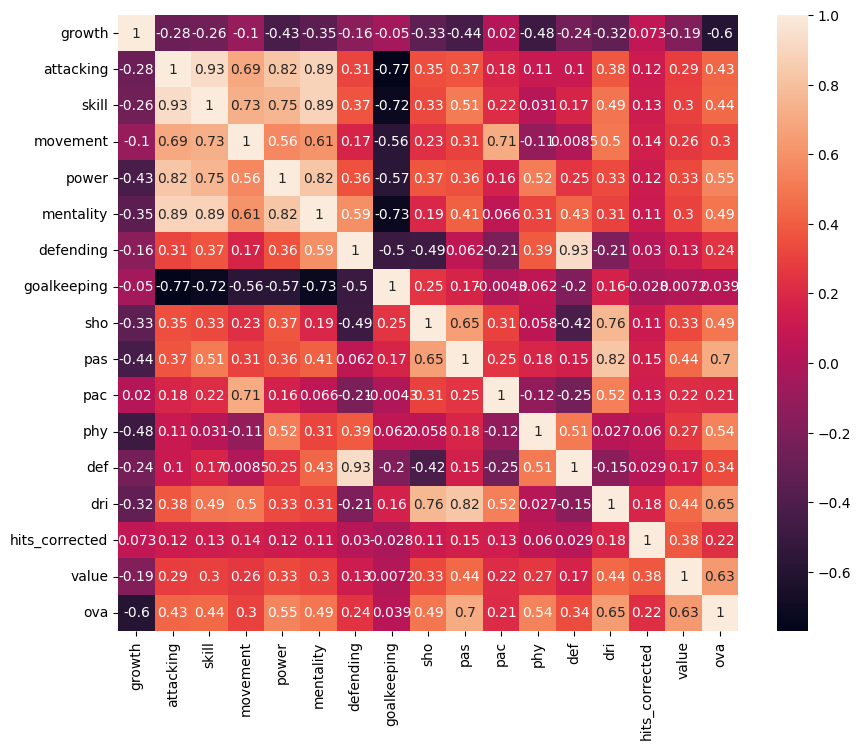

In [175]:
# correlation in heatmap
# correlations_matrix = df.corr()
# sns.heatmap(correlations_matrix, annot=True)
# plt.show()
fig,ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(df.corr(), annot=True)
plt.show()


In [176]:
# correlation matrix
correlations_matrix = df.corr()
display(correlations_matrix)
df.shape

,growth,attacking,skill,movement,power,mentality,defending,goalkeeping,sho,pas,pac,phy,def,dri,hits_corrected,value,ova
growth,1.000000,-0.281668,-0.262893,-0.101370,-0.427800,-0.348028,-0.157743,-0.050320,-0.334891,-0.439781,0.019677,-0.484123,-0.240244,-0.320569,0.073142,-0.186735,-0.596642
attacking,-0.281668,1.000000,0.928584,0.692493,0.823527,0.888604,0.311367,-0.769826,0.349931,0.370180,0.181119,0.107896,0.103203,0.379978,0.118695,0.286165,0.433092
skill,-0.262893,0.928584,1.000000,0.725776,0.753061,0.885893,0.370432,-0.716263,0.325009,0.514101,0.217046,0.031079,0.171817,0.486271,0.126711,0.297288,0.442666
movement,-0.101370,0.692493,0.725776,1.000000,0.560489,0.610661,0.174070,-0.563037,0.227513,0.307423,0.705488,-0.111590,0.008547,0.497619,0.142825,0.262040,0.304496
power,-0.427800,0.823527,0.753061,0.560489,1.000000,0.823428,0.361816,-0.573683,0.374796,0.355994,0.157692,0.519953,0.248330,0.332691,0.116732,0.326979,0.547839
mentality,-0.348028,0.888604,0.885893,0.610661,0.823428,1.000000,0.587906,-0.727656,0.186766,0.408774,0.065620,0.312193,0.429305,0.308240,0.112109,0.303380,0.494590
defending,-0.157743,0.311367,0.370432,0.174070,0.361816,0.587906,1.000000,-0.496275,-0.485337,0.061623,-0.213725,0.388696,0.928767,-0.205621,0.029545,0.127014,0.243725
goalkeeping,-0.050320,-0.769826,-0.716263,-0.563037,-0.573683,-0.727656,-0.496275,1.000000,0.246624,0.171304,-0.004254,0.062021,-0.199113,0.160553,-0.028421,0.007188,0.038584
sho,-0.334891,0.349931,0.325009,0.227513,0.374796,0.186766,-0.485337,0.246624,1.000000,0.651772,0.305295,0.057520,-0.419926,0.764479,0.113251,0.325187,0.492019
pas,-0.439781,0.370180,0.514101,0.307423,0.355994,0.408774,0.061623,0.171304,0.651772,1.000000,0.248108,0.177747,0.148632,0.820455,0.146046,0.444784,0.703290


(11701, 21)

In [177]:
# mentality has a very high correlations with attacking and skill (nearly 0.9) so we dropped it. but we didnt today
# growth and pac have very low correlation values with many columns, so we dropped them
# columns that we consider dropping: growth, value, goalkeeping, pac, mentality
cols = ["growth"]
for i in cols:
    try:
        df = df.drop(columns=[i], axis = 1)
        print("deleted the column.")
    except:
        print("column was already deleted.")


deleted the column.


In [178]:
# putting X-cat and X_num back together
X = pd.concat([x_normalized, onehot_encoded], axis=1)
X .head(1)


,growth,attacking,skill,movement,power,mentality,defending,goalkeeping,sho,pas,pac,phy,def,dri,hits_corrected,value,a/w_High,a/w_Low,a/w_Medium,d/w_High,d/w_Low,d/w_Medium,w/f_1,w/f_2,w/f_3,w/f_4,w/f_5,sm_1,sm_2,sm_3,sm_4,sm_5
0,0.074074,0.556931,0.569087,0.663818,0.55627,0.654596,0.524,0.084309,0.447368,0.558824,0.614286,0.5,0.506494,0.522388,0.0,0.005833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [179]:
# train test split
# fine-tuning train-test results for various test size
testsize = []
r2_train_list = []
r2_test_list = []
mse_train_list = []
mse_test_list = []
rmse_train_list = []
rmse_test_list = []
mae_train_list = []
mae_test_list = []
lm = linear_model.LinearRegression()
for i in range(1,10):
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/10, random_state=42)
    # fitting training model to LinearRegression, making a linear model
    lm.fit(X_train,y_train)
    # prediction values
    model = lm.predict(X_train)
    predict = lm.predict(X_test)
    # r2 values
    r2_train = lm.score(X_train, y_train)
    r2_test = lm.score(X_test, y_test)
    # mse values
    mse_train = mse(model, y_train)
    mse_test = mse(predict, y_test)
    # rmse values
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    # mae values
    mae_train = mae(model, y_train)
    mae_test = mae(predict, y_test)
    # appending to the lists
    testsize.append(i/10)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)

metrics = pd.DataFrame()
metrics["test size"] = pd.DataFrame(testsize)
metrics["R2 train"] = pd.DataFrame(r2_train_list)
metrics["R2 test"] = pd.DataFrame(r2_test_list)
metrics["MSE train"] = pd.DataFrame(mse_train_list)
metrics["MSE test"] = pd.DataFrame(mse_test_list)
metrics["RMSE train"] = pd.DataFrame(rmse_train_list)
metrics["RMSE test"] = pd.DataFrame(rmse_test_list)
metrics["MAE train"] = pd.DataFrame(mae_train_list)
metrics["MAE test"] = pd.DataFrame(mae_test_list)

display(metrics)

,test size,R2 train,R2 test,MSE train,MSE test,RMSE train,RMSE test,MAE train,MAE test
0,0.1,0.840587,0.835980,7.570816,7.432470,2.751512,2.726256,2.157894,2.136702
1,0.2,0.846008,0.846360,7.271593,7.274932,2.696589,2.697208,2.101222,2.073468
2,0.3,0.845314,0.842024,7.291891,7.497431,2.700350,2.738144,2.090274,2.080639
3,0.4,0.848474,0.842499,7.165463,7.436628,2.676838,2.727018,2.080295,2.101950
4,0.5,0.847898,0.841177,7.151661,7.546388,2.674259,2.747069,2.086896,2.127612
5,0.6,0.847593,0.843978,7.029630,7.491641,2.651345,2.737086,2.058964,2.106324
6,0.7,0.836628,0.834659,7.547313,7.890416,2.747237,2.808988,2.154015,2.197435
7,0.8,0.852652,0.839927,6.923968,7.576861,2.631343,2.752610,2.038812,2.117192
8,0.9,0.853604,0.837652,6.933798,7.673033,2.633210,2.770024,2.051691,2.136680


In [180]:
# comparing the train results with test results
# if train is bigger than test, then 1
# if test is bigger than train, then 0
compare = []
compare_r2 = []
compare_mse = []
compare_rmse = []
compare_mae = []
for i in range(len(metrics["test size"])):
    if metrics["R2 train"][i] > metrics["R2 test"][i]:
        compare_r2.append(1)
    else: 
        compare_r2.append(0)
    if metrics["MSE train"][i] > metrics["MSE test"][i]:
        compare_mse.append(1)
    else: 
        compare_mse.append(0)
    if metrics["RMSE train"][i] > metrics["RMSE test"][i]:
        compare_rmse.append(1)
    else: 
        compare_rmse.append(0)
    if metrics["MAE train"][i] > metrics["MAE test"][i]:
        compare_mae.append(1)
    else: 
        compare_mae.append(0) 

compare = pd.DataFrame()
compare["test size"] = pd.DataFrame(testsize)
compare["R2"] = pd.DataFrame(compare_r2)
compare["MSE"] = pd.DataFrame(compare_mse)
compare["RMSE"] = pd.DataFrame(compare_rmse)
compare["MAE"] = pd.DataFrame(compare_mae)
display(compare)


,test size,R2,MSE,RMSE,MAE
0,0.1,1,1,1,1
1,0.2,0,0,0,1
2,0.3,1,0,0,1
3,0.4,1,0,0,0
4,0.5,1,0,0,0
5,0.6,1,0,0,0
6,0.7,1,0,0,0
7,0.8,1,0,0,0
8,0.9,1,0,0,0


In [181]:
# 0.1 is the best test size
# sets the model to be used. this is where the model learns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # using the testsize we chose
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
# to be used on the new data
predict = lm.predict(X_test)
r2_test = lm.score(X_test, y_test)
mse_test = mse(predict, y_test)
rmse_test = np.sqrt(mse_test)
mae_test = mae(predict, y_test)

In [182]:
# the test size 0.1 provides best results, in terms that
# all train results are higher than test results
# (shown with value "1" for every comparison where train > test)

## calling new data now

In [183]:
data_new = pd.read_csv("fifa21_validate.csv")
data_new.head()

,ID,Name,Age,Nationality,Club,BP,Position,Team & Contract,Height,Weight,foot,Growth,Joined,Loan Date End,Value,Wage,Release Clause,Contract,Attacking,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending,Marking,Standing Tackle,Sliding Tackle,Goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,W/F,SM,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,219461,E. Palmer-Brown,23,United States,FK Austria Wien,CB,CB,"FK Austria Wien Jun 30, 2021 On Loan","6'2""",194lbs,Right,7,"Feb 8, 2018","Jun 30, 2021",€975K,€5K,€0,"Jun 30, 2021 On Loan",230,47,21,62,60,40.0,228,44,43.0,36,51,54,303,60,68,63.0,63,49.0,288,48,77.0,51,87,25,246,68,62.0,38.0,39.0,39,49.0,200,68,67,65.0,56,11,8,15,13,9,1551,334,2 ★,2★,Low,High,1 ★,64,30,50,50,66,74,34,48+2,48+2,48+2,48+0,47+0,47+0,47+0,48+0,48+2,48+2,48+2,50+2,51+2,51+2,51+2,50+2,59+2,61+2,61+2,61+2,59+2,61+2,67+2,67+2,67+2,61+2,16+2,67
1,221896,D. Avdijaj,22,Kosovo,Heart of Midlothian,CAM,LM CAM,Heart of Midlothian 2020 ~ 2020,"5'8""",154lbs,Right,5,"Jan 20, 2020",NaN,€1.2M,€3K,€2.2M,2020 ~ 2020,298,62,60,44,62,70.0,330,76,68.0,56,60,70,375,77,72,83.0,64,79.0,323,76,62.0,63,47,75,286,72,26.0,64.0,64.0,60,65.0,61,19,23,19.0,53,14,13,9,9,8,1726,358,4 ★,3★,High,Low,1 ★,74,67,62,74,24,57,12,64+2,64+2,64+2,68+0,68+0,68+0,68+0,68+0,68+2,68+2,68+2,67+2,61+2,61+2,61+2,67+2,49+2,47+2,47+2,47+2,49+2,45+2,38+2,38+2,38+2,45+2,17+2,68
2,247428,D. Ochoa,19,United States,Real Salt Lake,GK,GK,Real Salt Lake 2018 ~ 2020,"6'2""",176lbs,Right,17,"Nov 28, 2018",NaN,€120K,€500,€249K,2018 ~ 2020,48,7,5,11,21,4.0,52,6,8.0,8,20,10,165,28,25,33.0,41,38.0,171,40,49.0,22,54,6,76,20,9.0,7.0,26.0,14,31.0,27,8,9,10.0,269,56,52,53,53,55,808,295,2 ★,1★,Medium,Medium,1 ★,56,52,53,55,26,53,3,18+2,18+2,18+2,15+0,17+0,17+0,17+0,15+0,17+2,17+2,17+2,16+2,18+2,18+2,18+2,16+2,16+2,18+2,18+2,18+2,16+2,16+2,18+2,18+2,18+2,16+2,53+2,54
3,255120,N. Kenneh,16,England,Leeds United,CDM,CB CDM RB,Leeds United 2020 ~ 2022,"6'3""",170lbs,Right,23,"Jan 10, 2020",NaN,€160K,€500,€464K,2020 ~ 2022,215,38,31,55,59,32.0,224,51,34.0,38,47,54,275,59,58,56.0,48,54.0,242,48,48.0,60,58,28,230,61,55.0,33.0,40.0,41,59.0,159,53,52,54.0,36,7,5,13,5,6,1381,303,3 ★,2★,Medium,Medium,1 ★,58,34,47,52,53,59,6,46+2,46+2,46+2,47+0,46+0,46+0,46+0,47+0,47+2,47+2,47+2,49+2,49+2,49+2,49+2,49+2,53+2,54+2,54+2,54+2,53+2,53+2,54+2,54+2,54+2,53+2,11+2,55
4,215556,E. Fernandes,24,Switzerland,1. FSV Mainz 05,CDM,CM CDM,1. FSV Mainz 05 2019 ~ 2023,"6'2""",170lbs,Right,5,"Jul 1, 2019",NaN,€2.3M,€13K,€4.3M,2019 ~ 2023,295,57,59,45,78,56.0,327,71,57.0,51,74,74,320,68,66,66.0,64,56.0,337,73,56.0,74,72,62,314,66,78.0,53.0,62.0,55,63.0,211,72,68,71.0,60,12,7,13,15,13,1864,407,4 ★,2★,Medium,Medium,1 ★,67,62,68,70,69,71,45,63+2,63+2,63+2,66+0,66+0,66+0,66+0,66+0,68+2,68+2,68+2,67+2,70+2,70+2,70+2,67+2,70+2,72+2,72+2,72+2,70+2,69+2,68+2,68+2,68+2,69+2,18+2,70


In [184]:
cols=[]
for i in data_new.columns:
    cols.append(i.lower())
data_new.columns = cols
data_new.columns = data_new.columns.str.replace(' ', '_')

In [185]:
# removing star signs
cols = ["w/f","ir","sm"]
for i in cols:
    data_new[i] = data_new[i].str.replace('★', '')

In [186]:
display(data_new['a/w'].value_counts())
display(data_new['d/w'].value_counts())

Medium    1314
High       595
Low         82
Name: a/w, dtype: int64

Medium    1464
High       333
Low        194
Name: d/w, dtype: int64

In [187]:
# filling NaNs with median value
data_new['a/w'] = data_new['a/w'].fillna('Medium')
data_new['d/w'] = data_new['d/w'].fillna('Medium')

In [188]:
# removing duplicates, just in case
duplicate = data_new[data_new.duplicated()]
print(len(duplicate))
# dropping duplicates, then check again to make sure
data_new = data_new.drop_duplicates()
duplicate = data_new[data_new.duplicated()]
display(duplicate)
print(len(duplicate))

0


,id,name,age,nationality,club,bp,position,team_&_contract,height,weight,foot,growth,joined,loan_date_end,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,w/f,sm,a/w,d/w,ir,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,ova


0


In [189]:
# converting K to 10e+03 and M to 10e+06
def value_to_float(x):
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    else:
        return float(x)
try:
    data_new['value'] = data_new['value'].str.replace('€', '')
except:
    pass
data_new['hits_corrected'] = data_new['hits'].apply(value_to_float)
data_new['value'] = data_new['value'].apply(value_to_float)
data_new.head()

,id,name,age,nationality,club,bp,position,team_&_contract,height,weight,foot,growth,joined,loan_date_end,value,wage,release_clause,contract,attacking,crossing,finishing,heading_accuracy,short_passing,volleys,skill,dribbling,curve,fk_accuracy,long_passing,ball_control,movement,acceleration,sprint_speed,agility,reactions,balance,power,shot_power,jumping,stamina,strength,long_shots,mentality,aggression,interceptions,positioning,vision,penalties,composure,defending,marking,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats,w/f,sm,a/w,d/w,ir,pac,sho,pas,dri,def,phy,hits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,ova,hits_corrected
0,219461,E. Palmer-Brown,23,United States,FK Austria Wien,CB,CB,"FK Austria Wien Jun 30, 2021 On Loan","6'2""",194lbs,Right,7,"Feb 8, 2018","Jun 30, 2021",975000.0,€5K,€0,"Jun 30, 2021 On Loan",230,47,21,62,60,40.0,228,44,43.0,36,51,54,303,60,68,63.0,63,49.0,288,48,77.0,51,87,25,246,68,62.0,38.0,39.0,39,49.0,200,68,67,65.0,56,11,8,15,13,9,1551,334,2,2,Low,High,1,64,30,50,50,66,74,34,48+2,48+2,48+2,48+0,47+0,47+0,47+0,48+0,48+2,48+2,48+2,50+2,51+2,51+2,51+2,50+2,59+2,61+2,61+2,61+2,59+2,61+2,67+2,67+2,67+2,61+2,16+2,67,34.0
1,221896,D. Avdijaj,22,Kosovo,Heart of Midlothian,CAM,LM CAM,Heart of Midlothian 2020 ~ 2020,"5'8""",154lbs,Right,5,"Jan 20, 2020",NaN,1200000.0,€3K,€2.2M,2020 ~ 2020,298,62,60,44,62,70.0,330,76,68.0,56,60,70,375,77,72,83.0,64,79.0,323,76,62.0,63,47,75,286,72,26.0,64.0,64.0,60,65.0,61,19,23,19.0,53,14,13,9,9,8,1726,358,4,3,High,Low,1,74,67,62,74,24,57,12,64+2,64+2,64+2,68+0,68+0,68+0,68+0,68+0,68+2,68+2,68+2,67+2,61+2,61+2,61+2,67+2,49+2,47+2,47+2,47+2,49+2,45+2,38+2,38+2,38+2,45+2,17+2,68,12.0
2,247428,D. Ochoa,19,United States,Real Salt Lake,GK,GK,Real Salt Lake 2018 ~ 2020,"6'2""",176lbs,Right,17,"Nov 28, 2018",NaN,120000.0,€500,€249K,2018 ~ 2020,48,7,5,11,21,4.0,52,6,8.0,8,20,10,165,28,25,33.0,41,38.0,171,40,49.0,22,54,6,76,20,9.0,7.0,26.0,14,31.0,27,8,9,10.0,269,56,52,53,53,55,808,295,2,1,Medium,Medium,1,56,52,53,55,26,53,3,18+2,18+2,18+2,15+0,17+0,17+0,17+0,15+0,17+2,17+2,17+2,16+2,18+2,18+2,18+2,16+2,16+2,18+2,18+2,18+2,16+2,16+2,18+2,18+2,18+2,16+2,53+2,54,3.0
3,255120,N. Kenneh,16,England,Leeds United,CDM,CB CDM RB,Leeds United 2020 ~ 2022,"6'3""",170lbs,Right,23,"Jan 10, 2020",NaN,160000.0,€500,€464K,2020 ~ 2022,215,38,31,55,59,32.0,224,51,34.0,38,47,54,275,59,58,56.0,48,54.0,242,48,48.0,60,58,28,230,61,55.0,33.0,40.0,41,59.0,159,53,52,54.0,36,7,5,13,5,6,1381,303,3,2,Medium,Medium,1,58,34,47,52,53,59,6,46+2,46+2,46+2,47+0,46+0,46+0,46+0,47+0,47+2,47+2,47+2,49+2,49+2,49+2,49+2,49+2,53+2,54+2,54+2,54+2,53+2,53+2,54+2,54+2,54+2,53+2,11+2,55,6.0
4,215556,E. Fernandes,24,Switzerland,1. FSV Mainz 05,CDM,CM CDM,1. FSV Mainz 05 2019 ~ 2023,"6'2""",170lbs,Right,5,"Jul 1, 2019",NaN,2300000.0,€13K,€4.3M,2019 ~ 2023,295,57,59,45,78,56.0,327,71,57.0,51,74,74,320,68,66,66.0,64,56.0,337,73,56.0,74,72,62,314,66,78.0,53.0,62.0,55,63.0,211,72,68,71.0,60,12,7,13,15,13,1864,407,4,2,Medium,Medium,1,67,62,68,70,69,71,45,63+2,63+2,63+2,66+0,66+0,66+0,66+0,66+0,68+2,68+2,68+2,67+2,70+2,70+2,70+2,67+2,70+2,72+2,72+2,72+2,70+2,69+2,68+2,68+2,68+2,69+2,18+2,70,45.0


In [190]:
# only take columns we deem relevant to calculating the OVA from the complete dataset
need = ["growth","attacking","skill","movement","power","mentality","defending","goalkeeping","sho","pas","pac","phy","def","dri","a/w","d/w","hits_corrected","value","w/f","sm","ova"]
df_new = data_new.filter(need, axis=1)
df_new.head(1)

,growth,attacking,skill,movement,power,mentality,defending,goalkeeping,sho,pas,pac,phy,def,dri,a/w,d/w,hits_corrected,value,w/f,sm,ova
0,7,230,228,303,288,246,200,56,30,50,64,74,66,50,Low,High,34.0,975000.0,2,2,67


In [191]:
# is there any NaN's left?
df_new.isna().sum()

growth            0
attacking         0
skill             0
movement          0
power             0
mentality         0
defending         0
goalkeeping       0
sho               0
pas               0
pac               0
phy               0
def               0
dri               0
a/w               0
d/w               0
hits_corrected    0
value             0
w/f               0
sm                0
ova               0
dtype: int64

In [192]:
# defining the y and X; splitting nums and cats
y_new = df_new['ova']
X_new = df_new.drop(['ova'], axis=1)
X_num_new = pd.DataFrame(X_new.select_dtypes(np.number))
X_cat_new = pd.DataFrame(X_new.select_dtypes(object))

In [193]:
# encoding categorical data with OneHot
encoder_new = OneHotEncoder().fit(X_cat_new)
# putting the mold to work for the categorical data (?), then make an array out of it
cat_encoded_new = encoder_new.transform(X_cat_new).toarray()
# getting the column names
cols = encoder_new.get_feature_names_out(input_features=X_cat_new.columns)
# turning it into dataframe
onehot_encoded_new = pd.DataFrame(cat_encoded_new,columns=cols)
onehot_encoded_new.head(10)

,a/w_High,a/w_Low,a/w_Medium,d/w_High,d/w_Low,d/w_Medium,w/f_1,w/f_2,w/f_3,w/f_4,w/f_5,sm_1,sm_2,sm_3,sm_4,sm_5
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [194]:
# Scaling numerical data with MinMax
transformer_new = MinMaxScaler().fit(X_num_new)
# producing the "normalized" value, but dont produce the dataframe/series/list (yet)
x_normalized_new = transformer_new.transform(X_num_new)
# it needs to be made a dataframe first to see it in a better manner
x_normalized_new = pd.DataFrame(x_normalized_new, columns=X_num_new.columns)

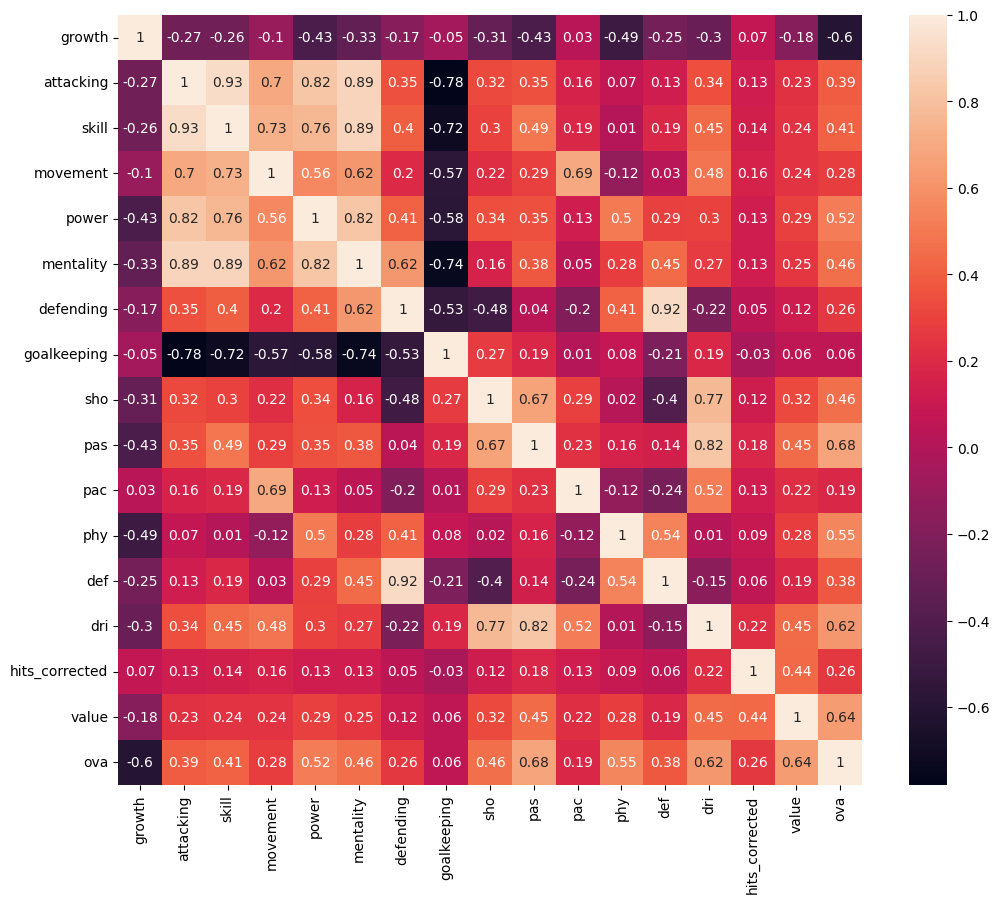

In [195]:
# correlation in heatmap
fig,ax=plt.subplots(figsize=(12, 10))
ax=sns.heatmap(df_new.corr().round(2), annot=True)
plt.show()


In [196]:
# correlation matrix
correlations_matrix_new = df_new.corr()
display(correlations_matrix_new)
df_new.shape

,growth,attacking,skill,movement,power,mentality,defending,goalkeeping,sho,pas,pac,phy,def,dri,hits_corrected,value,ova
growth,1.000000,-0.270542,-0.255268,-0.095228,-0.430269,-0.330383,-0.167799,-0.046883,-0.314518,-0.430657,0.031670,-0.486094,-0.251498,-0.298014,0.072491,-0.180448,-0.595787
attacking,-0.270542,1.000000,0.929191,0.703217,0.820976,0.893179,0.352263,-0.781167,0.318886,0.345790,0.155972,0.072133,0.130852,0.338376,0.133288,0.226189,0.388874
skill,-0.255268,0.929191,1.000000,0.732524,0.756487,0.888776,0.403722,-0.723680,0.301536,0.493936,0.192671,0.006677,0.192484,0.446999,0.139205,0.243333,0.405149
movement,-0.095228,0.703217,0.732524,1.000000,0.557385,0.624733,0.203862,-0.574313,0.217127,0.293709,0.690968,-0.123733,0.029831,0.481462,0.156054,0.242011,0.282904
power,-0.430269,0.820976,0.756487,0.557385,1.000000,0.823917,0.408896,-0.580167,0.340599,0.348786,0.127349,0.497964,0.293070,0.304918,0.133725,0.285431,0.522820
mentality,-0.330383,0.893179,0.888776,0.624733,0.823917,1.000000,0.617171,-0.741886,0.158057,0.384164,0.051462,0.282160,0.448722,0.269528,0.134944,0.252473,0.461711
defending,-0.167799,0.352263,0.403722,0.203862,0.408896,0.617171,1.000000,-0.528058,-0.479614,0.042068,-0.202687,0.405227,0.921428,-0.217191,0.054983,0.118630,0.263812
goalkeeping,-0.046883,-0.781167,-0.723680,-0.574313,-0.580167,-0.741886,-0.528058,1.000000,0.267017,0.190171,0.012232,0.078710,-0.213255,0.191799,-0.029032,0.064013,0.060945
sho,-0.314518,0.318886,0.301536,0.217127,0.340599,0.158057,-0.479614,0.267017,1.000000,0.670608,0.293327,0.015746,-0.403835,0.770033,0.121556,0.321238,0.459360
pas,-0.430657,0.345790,0.493936,0.293709,0.348786,0.384164,0.042068,0.190171,0.670608,1.000000,0.232815,0.161920,0.139240,0.818899,0.177509,0.448998,0.683020


(1999, 21)

In [197]:
# mentality has a very high correlations with attacking and skill (nearly 0.9) so we dropped it. but we didnt today
# growth and pac have very low correlation values with many columns, so we dropped them
# columns that we consider dropping: growth, value, goalkeeping, pac, mentality
cols = ["growth"]
for i in cols:
    try:
        df_new = df_new.drop(columns=[i], axis = 1)
        print("deleted the column.")
    except:
        print("column was already deleted.")

deleted the column.


In [198]:
X_new = pd.concat([x_normalized_new, onehot_encoded_new], axis=1)

In [199]:
X_new.head(20)

,growth,attacking,skill,movement,power,mentality,defending,goalkeeping,sho,pas,pac,phy,def,dri,hits_corrected,value,a/w_High,a/w_Low,a/w_Medium,d/w_High,d/w_Low,d/w_Medium,w/f_1,w/f_2,w/f_3,w/f_4,w/f_5,sm_1,sm_2,sm_3,sm_4,sm_5
0,0.28,0.509804,0.463158,0.535503,0.541219,0.517906,0.708502,0.097156,0.138889,0.328125,0.531250,0.719298,0.688312,0.327869,0.010344,0.012500,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.20,0.700280,0.731579,0.748521,0.666667,0.628099,0.145749,0.090047,0.652778,0.515625,0.687500,0.421053,0.142857,0.721311,0.003003,0.015385,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.68,0.000000,0.000000,0.127219,0.121864,0.049587,0.008097,0.601896,0.444444,0.375000,0.406250,0.350877,0.168831,0.409836,0.000000,0.001538,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.92,0.467787,0.452632,0.452663,0.376344,0.473829,0.542510,0.049763,0.194444,0.281250,0.437500,0.456140,0.519481,0.360656,0.001001,0.002051,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.20,0.691877,0.723684,0.585799,0.716846,0.705234,0.753036,0.106635,0.583333,0.609375,0.578125,0.666667,0.727273,0.655738,0.014014,0.029487,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.20,0.543417,0.560526,0.727811,0.684588,0.581267,0.502024,0.078199,0.486111,0.359375,0.843750,0.666667,0.454545,0.524590,0.000000,0.004167,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.88,0.453782,0.347368,0.594675,0.333333,0.396694,0.566802,0.068720,0.083333,0.203125,0.609375,0.421053,0.519481,0.393443,0.010677,0.003205,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.36,0.028011,0.028947,0.047337,0.150538,0.096419,0.012146,0.630332,0.500000,0.421875,0.437500,0.368421,0.181818,0.442623,0.000000,0.001282,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.40,0.509804,0.402632,0.710059,0.473118,0.418733,0.137652,0.099526,0.472222,0.218750,0.703125,0.228070,0.129870,0.442623,0.000334,0.001667,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.16,0.686275,0.689474,0.591716,0.591398,0.636364,0.530364,0.099526,0.555556,0.546875,0.562500,0.491228,0.493506,0.557377,0.000000,0.007372,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [200]:
# train test split
# lm = linear_model.LinearRegression()
predict_new = lm.predict(X_new)
r2_new = lm.score(X_new, y_new)
mse_new = mse(predict_new, y_new)
rmse_new = np.sqrt(mse_new)
mae_new = mae(predict_new, y_new)


In [201]:
res = []
r2_res = [r2_test, r2_new]
mse_res = [mse_test, mse_new]
rmse_res = [rmse_test, rmse_new]
mae_res = [mae_test, mae_new]
label = ["prediction","new"]
res = pd.DataFrame()
res["value"] = pd.DataFrame(label)
res["R2"] = pd.DataFrame(r2_res)
res["MSE"] = pd.DataFrame(mse_res)
res["RMSE"] = pd.DataFrame(rmse_res)
res["MAE"] = pd.DataFrame(mae_res)
display(res)

,value,R2,MSE,RMSE,MAE
0,prediction,0.835980,7.432470,2.726256,2.136702
1,new,0.804959,8.925356,2.987533,2.320879


In [202]:
len(X_train.columns)

32